In [ ]:
!pip install shapely pandas scikit-learn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

MSE: 0.002


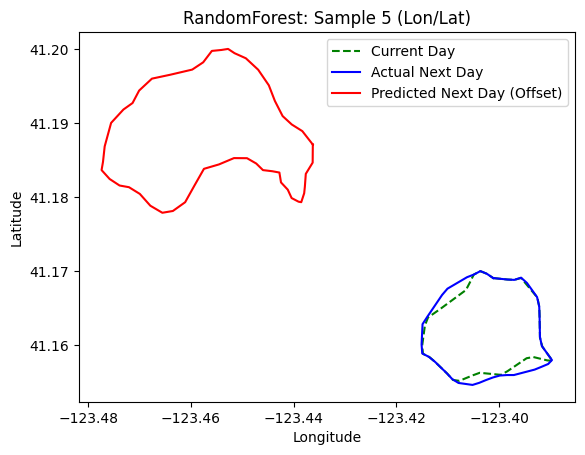

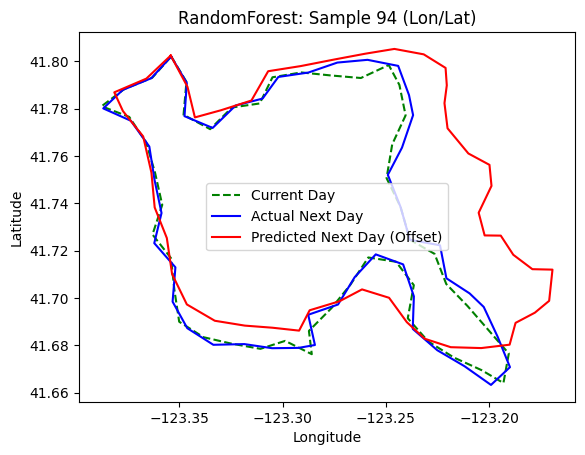

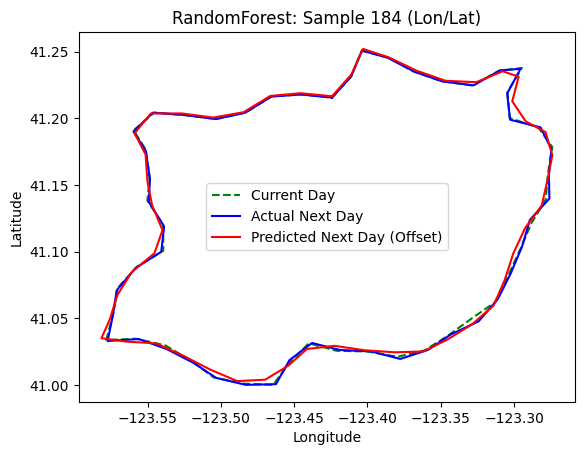

In [169]:
import numpy as np
import pandas as pd

import shapely.wkt
from shapely.geometry import Polygon, MultiPolygon

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import random
from joblib import dump


###############################################################################
# 1. LOAD & CLEAN
###############################################################################

# Replace with your actual CSV path and relevant columns.
# We expect columns:
#   fire_name, date, direction, temperature, windspeed, geometry, geometry_next
df = pd.read_csv("Final.csv")

# Drop columns you do not need
df = df.drop(["fire_name", "date"], axis=1)

# Helper to parse WKT into a Shapely polygon or multipolygon
def parse_polygon(geom_str):
    return shapely.wkt.loads(geom_str)

df["poly_current"] = df["geometry"].apply(parse_polygon)
df["poly_next"]    = df["geometry_next"].apply(parse_polygon)

###############################################################################
# 2. CONVERT MULTIPOLYGON -> SINGLE POLYGON
###############################################################################

def get_largest_polygon(poly):
    """
    If 'poly' is a MultiPolygon, return the sub-polygon with the largest area.
    If it's already a Polygon, return it as is.
    """
    if isinstance(poly, MultiPolygon):
        return max(poly.geoms, key=lambda g: g.area)
    elif isinstance(poly, Polygon):
        return poly
    else:
        raise ValueError(f"Geometry is neither Polygon nor MultiPolygon: {type(poly)}")

df["poly_current"] = df["poly_current"].apply(get_largest_polygon)
df["poly_next"]    = df["poly_next"].apply(get_largest_polygon)

###############################################################################
# 3. RESAMPLE POLYGON BOUNDARIES
###############################################################################

def resample_polygon(poly, n_points=50):
    """
    Evenly resample a single polygon boundary to exactly n_points.
    Returns a flat array: [lon0, lat0, lon1, lat1, ..., lon_{n-1}, lat_{n-1}].
    """
    coords = np.array(poly.exterior.coords)
    perimeter = sum(np.hypot(coords[i+1, 0] - coords[i, 0], coords[i+1, 1] - coords[i, 1]) for i in range(len(coords) - 1))
    spacing = perimeter / (n_points - 1)

    resampled = []
    segment_start = 0.0
    current_segment = 0

    for i in range(n_points):
        target_dist = i * spacing
        while True:
            p1 = coords[current_segment]
            p2 = coords[current_segment + 1]
            seg_len = np.hypot(p2[0] - p1[0], p2[1] - p1[1])
            if segment_start + seg_len >= target_dist or current_segment == len(coords) - 2:
                ratio = (target_dist - segment_start) / seg_len if seg_len else 0
                lon = p1[0] + ratio * (p2[0] - p1[0])
                lat = p1[1] + ratio * (p2[1] - p1[1])
                resampled.append([lon, lat])
                break
            else:
                segment_start += seg_len
                current_segment += 1
    return np.array(resampled).flatten()

df["poly_current_resampled"] = df["poly_current"].apply(lambda p: resample_polygon(p, n_points=50))
df["poly_next_resampled"]    = df["poly_next"].apply(lambda p: resample_polygon(p, n_points=50))

###############################################################################
# 4. BUILD FEATURE MATRIX (X) AND TARGET (y)
###############################################################################

X_list = []
y_list = []

for idx, row in df.iterrows():
    direction   = row["direction"]
    temperature = row["temperature"]
    windspeed   = row["windspeed"]

    current_poly_flat = row["poly_current_resampled"]
    next_poly_flat    = row["poly_next_resampled"]

    features = np.concatenate(([direction, temperature, windspeed], current_poly_flat))
    X_list.append(features)
    y_list.append(next_poly_flat)

X = np.array(X_list)
y = np.array(y_list)

###############################################################################
# 5. TRAIN/TEST SPLIT
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###############################################################################
# 6. TRAIN & EVALUATE MODELS
###############################################################################
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
dump(rf_model, "random_forest_model.joblib")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.3f}")

# Plot 3 samples with slight offset for predicted polygons
sample_indices = random.sample(range(len(y_test)), 3)
for idx in sample_indices:
    fig, ax = plt.subplots()

    # CURRENT DAY polygon
    current_poly_flat = X_test[idx, 3:]  # Skip direction/temp/wind
    current_coords = current_poly_flat.reshape(-1, 2)

    # PREDICTED NEXT-DAY polygon
    pred_poly_flat = y_pred[idx]
    pred_coords = pred_poly_flat.reshape(-1, 2)

    # ACTUAL NEXT-DAY polygon
    actual_poly_flat = y_test[idx]
    actual_coords = actual_poly_flat.reshape(-1, 2)

    # Slight offset for predicted polygon to avoid overlap
    pred_coords[:, 1] += 0.001  # Slightly increase latitude

    # Plot them
    ax.plot(current_coords[:, 0], current_coords[:, 1], 'g--', label='Current Day')
    ax.plot(actual_coords[:, 0], actual_coords[:, 1], 'b-', label='Actual Next Day')
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], 'r-', label='Predicted Next Day (Offset)')

    ax.legend()
    ax.set_title(f'{name}: Sample {idx} (Lon/Lat)')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()



=== LinearRegression ===
MSE: 0.002
MAE: 0.025
R2 Score: 0.999
Explained Variance: 0.999
Model saved as: linearregression_model.joblib


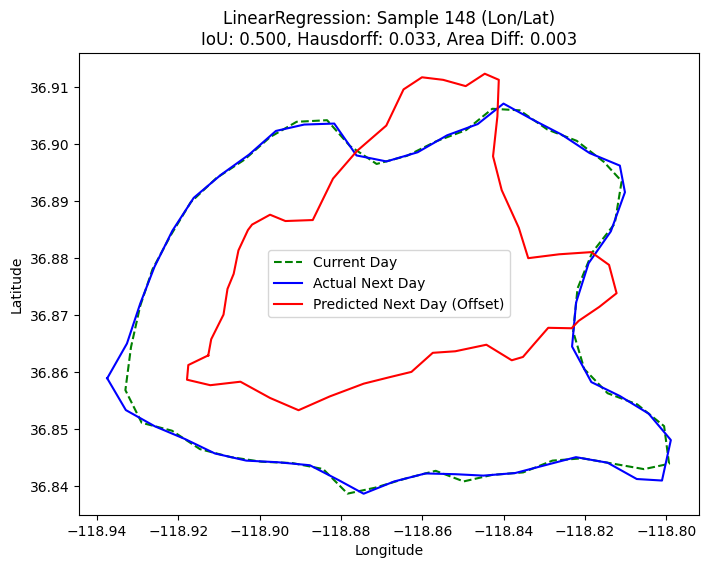

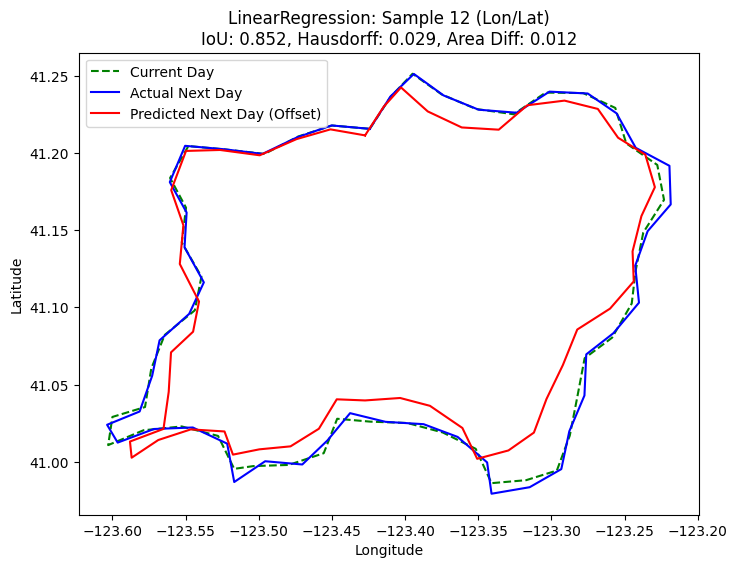

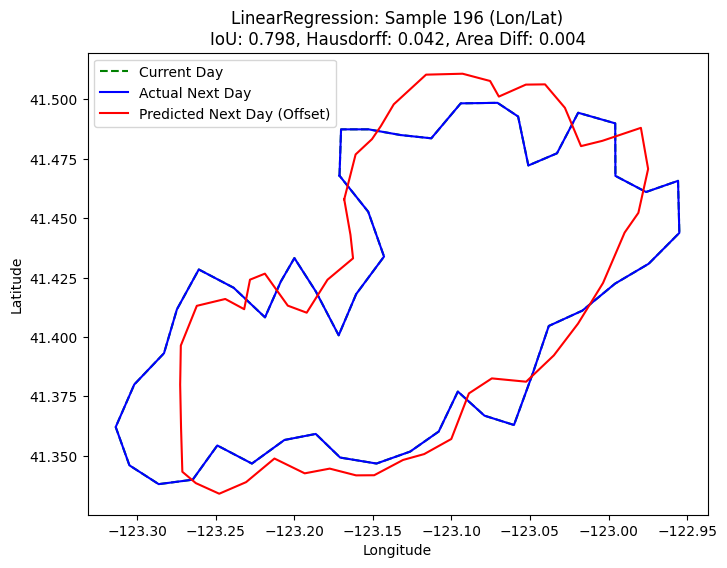

Average IoU: 0.716
Average Hausdorff Distance: 0.035
Average Area Difference: 0.006

=== Ridge ===
MSE: 0.002
MAE: 0.021
R2 Score: 0.999
Explained Variance: 0.999
Model saved as: ridge_model.joblib


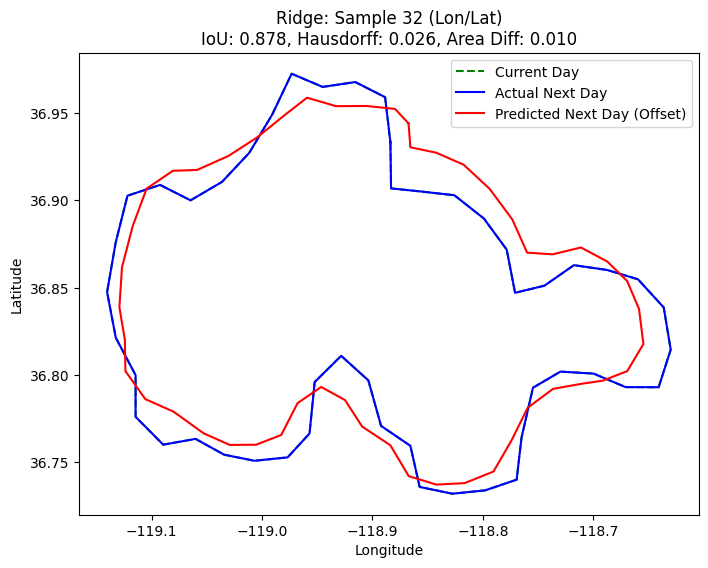

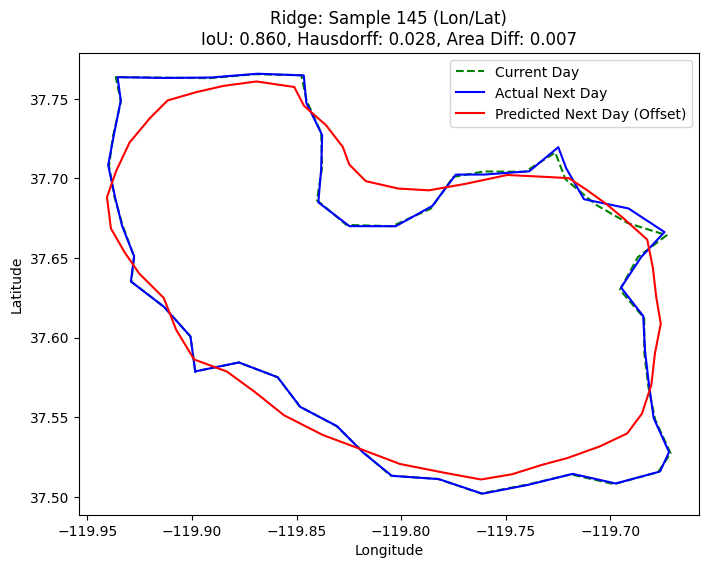

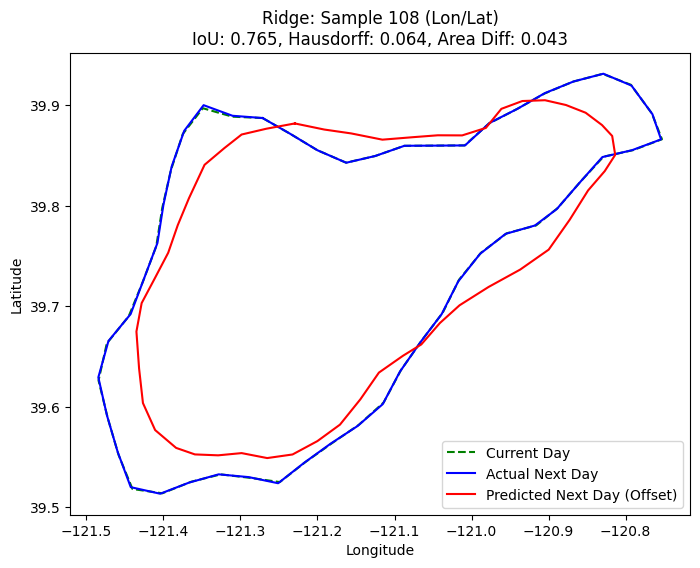

Average IoU: 0.834
Average Hausdorff Distance: 0.040
Average Area Difference: 0.020

=== Lasso ===
MSE: 0.002
MAE: 0.021
R2 Score: 0.999
Explained Variance: 0.999
Model saved as: lasso_model.joblib


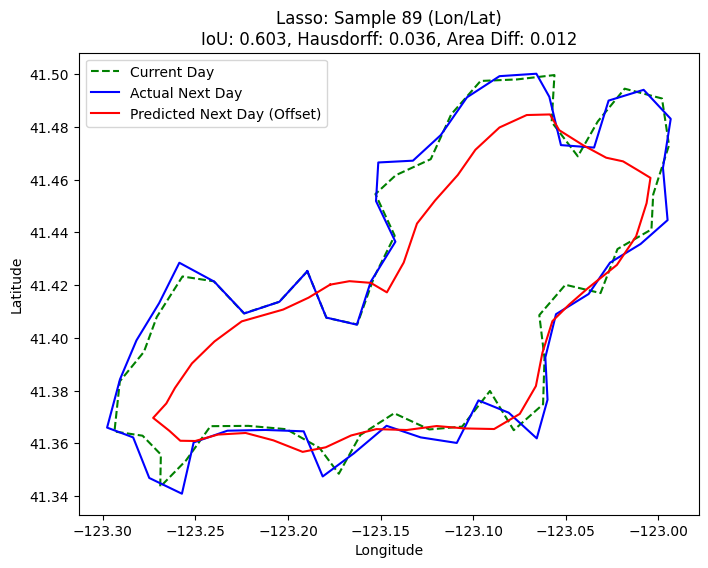

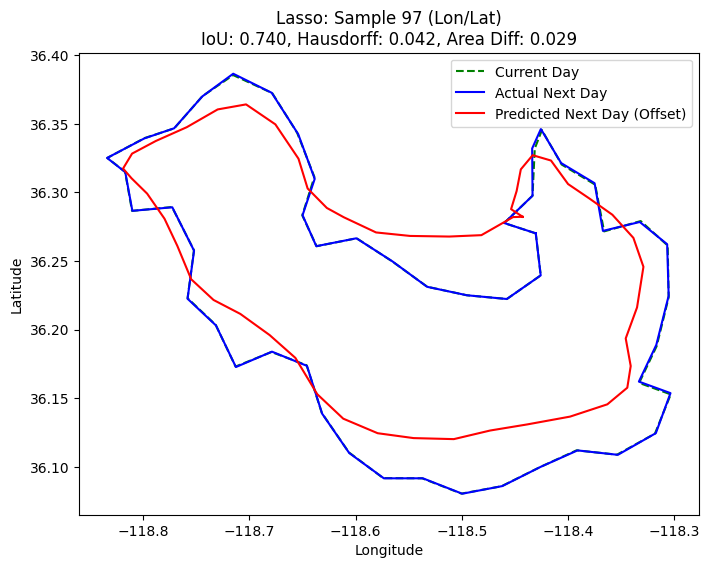

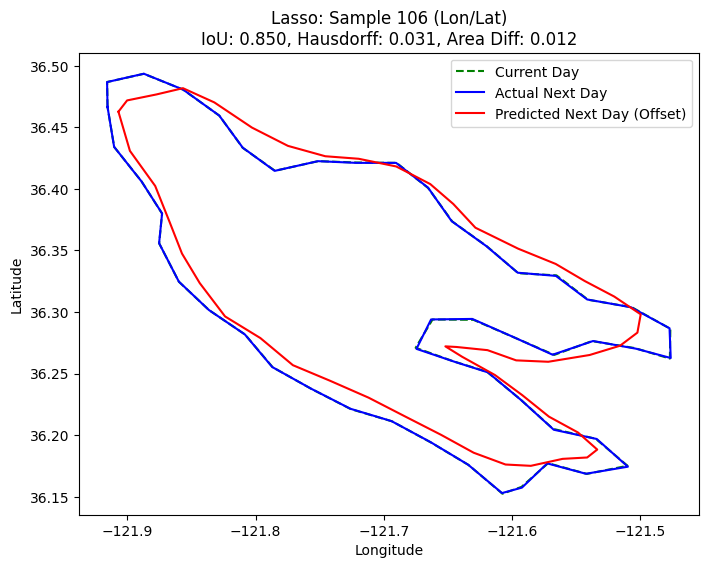

Average IoU: 0.731
Average Hausdorff Distance: 0.036
Average Area Difference: 0.018

Model Performance Comparison:

=== LinearRegression ===
MSE: 0.002
MAE: 0.025
R2: 0.999
Explained Variance: 0.999
IoU: 0.716
Hausdorff Distance: 0.035
Area Difference: 0.006

=== Ridge ===
MSE: 0.002
MAE: 0.021
R2: 0.999
Explained Variance: 0.999
IoU: 0.834
Hausdorff Distance: 0.040
Area Difference: 0.020

=== Lasso ===
MSE: 0.002
MAE: 0.021
R2: 0.999
Explained Variance: 0.999
IoU: 0.731
Hausdorff Distance: 0.036
Area Difference: 0.018


In [273]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import matplotlib.pyplot as plt
import random
from joblib import dump
from shapely.geometry import Polygon
from shapely.ops import unary_union
import numpy as np

# Define the models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),  # Increase iterations for convergence
}

# Initialize a results dictionary to store multiple metrics
results = {name: {} for name in models.keys()}

# Function to calculate IoU
def calculate_iou(pred_coords, actual_coords):
    try:
        pred_polygon = Polygon(pred_coords).convex_hull
        actual_polygon = Polygon(actual_coords).convex_hull
        if not pred_polygon.is_valid or not actual_polygon.is_valid:
            return 0.0
        intersection = pred_polygon.intersection(actual_polygon).area
        union = pred_polygon.union(actual_polygon).area
        if union == 0:
            return 0.0
        return intersection / union
    except Exception as e:
        print(f"Error in IoU calculation: {e}")
        return 0.0

# Function to calculate Hausdorff Distance
def calculate_hausdorff(pred_coords, actual_coords):
    try:
        pred_polygon = Polygon(pred_coords).convex_hull
        actual_polygon = Polygon(actual_coords).convex_hull
        return pred_polygon.hausdorff_distance(actual_polygon)
    except Exception as e:
        print(f"Error in Hausdorff Distance calculation: {e}")
        return np.nan

# Function to calculate Area Difference
def calculate_area_diff(pred_coords, actual_coords):
    try:
        pred_polygon = Polygon(pred_coords).convex_hull
        actual_polygon = Polygon(actual_coords).convex_hull
        return abs(pred_polygon.area - actual_polygon.area)
    except Exception as e:
        print(f"Error in Area Difference calculation: {e}")
        return np.nan

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate Regression Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    explained_var = explained_variance_score(y_test, y_pred)

    # Store Regression Metrics
    results[name]['MSE'] = mse
    results[name]['MAE'] = mae
    results[name]['R2'] = r2
    results[name]['Explained Variance'] = explained_var

    print(f"MSE: {mse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R2 Score: {r2:.3f}")
    print(f"Explained Variance: {explained_var:.3f}")

    # Initialize lists to store geometric metrics
    iou_list = []
    hausdorff_list = []
    area_diff_list = []

    # Save the trained model
    model_filename = f"{name.lower()}_model.joblib"
    dump(model, model_filename)
    print(f"Model saved as: {model_filename}")

    # Plot 3 random samples for visualization
    sample_indices = random.sample(range(len(y_test)), 3)
    for idx in sample_indices:
        fig, ax = plt.subplots(figsize=(8, 6))

        # CURRENT DAY polygon
        current_poly_flat = X_test[idx, 3:]  # Skip direction/temp/wind
        current_coords = current_poly_flat.reshape(-1, 2)

        # PREDICTED NEXT-DAY polygon
        pred_poly_flat = y_pred[idx]
        pred_coords = pred_poly_flat.reshape(-1, 2)

        # ACTUAL NEXT-DAY polygon
        actual_poly_flat = y_test[idx]
        actual_coords = actual_poly_flat.reshape(-1, 2)

        # Calculate geometric metrics
        iou = calculate_iou(pred_coords, actual_coords)
        hausdorff = calculate_hausdorff(pred_coords, actual_coords)
        area_diff = calculate_area_diff(pred_coords, actual_coords)

        iou_list.append(iou)
        hausdorff_list.append(hausdorff)
        area_diff_list.append(area_diff)

        # Slight offset for predicted polygon to avoid overlap
        pred_coords_offset = pred_coords.copy()
        pred_coords_offset[:, 1] += 0.001  # Slightly increase latitude

        # Plot them
        ax.plot(current_coords[:, 0], current_coords[:, 1], 'g--', label='Current Day')
        ax.plot(actual_coords[:, 0], actual_coords[:, 1], 'b-', label='Actual Next Day')
        ax.plot(pred_coords_offset[:, 0], pred_coords_offset[:, 1], 'r-', label='Predicted Next Day (Offset)')

        # Set plot title with geometric metrics
        ax.set_title(
            f"{name}: Sample {idx} (Lon/Lat)\n"
            f"IoU: {iou:.3f}, Hausdorff: {hausdorff:.3f}, Area Diff: {area_diff:.3f}"
        )
        ax.legend()
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.show()

    # Aggregate geometric metrics
    avg_iou = np.mean(iou_list)
    avg_hausdorff = np.nanmean(hausdorff_list)  # Handle NaNs
    avg_area_diff = np.nanmean(area_diff_list)

    # Store geometric metrics
    results[name]['IoU'] = avg_iou
    results[name]['Hausdorff Distance'] = avg_hausdorff
    results[name]['Area Difference'] = avg_area_diff

    print(f"Average IoU: {avg_iou:.3f}")
    print(f"Average Hausdorff Distance: {avg_hausdorff:.3f}")
    print(f"Average Area Difference: {avg_area_diff:.3f}")

# Compare Model Performances
print("\nModel Performance Comparison:")
for model_name, metrics in results.items():
    print(f"\n=== {model_name} ===")
    for metric_name, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric_name}: {value:.3f}")
        else:
            print(f"{metric_name}: {value}")


In [173]:
df = pd.read_csv("Final.csv")


In [276]:
import sys
version_info = sys.version_info
print(f"Python Version: {version_info.major}.{version_info.minor}.{version_info.micro}")


Python Version: 3.11.11


In [192]:
df.loc[30, "geometry"]

'POLYGON ((-122.49581 38.5331, -122.48946 38.53707, -122.49377 38.54429, -122.49822 38.54365, -122.49898 38.54697, -122.49974 38.55027, -122.49865 38.55135, -122.49167 38.55486, -122.48531 38.55922, -122.48382 38.56525, -122.4847 38.56856, -122.48555 38.57186, -122.4864 38.57516, -122.49162 38.57784, -122.49599 38.57721, -122.50033 38.57659, -122.50469 38.57596, -122.5118 38.5705, -122.50665 38.5654, -122.50584 38.5621, -122.50843 38.56119, -122.51481 38.55723, -122.51411 38.56167, -122.51302 38.56609, -122.51799 38.57103, -122.52306 38.57597, -122.52959 38.57201, -122.53514 38.57249, -122.54049 38.57295, -122.54593 38.57341, -122.55177 38.57391, -122.55086 38.57835, -122.55602 38.58331, -122.55011 38.5828, -122.54294 38.58671, -122.53687 38.58618, -122.53015 38.59012, -122.52405 38.59411, -122.51685 38.59799, -122.51519 38.60236, -122.50668 38.60613, -122.50071 38.6056, -122.49544 38.60514, -122.49647 38.60073, -122.49784 38.59634, -122.49342 38.59145, -122.48749 38.59093, -122.48297 

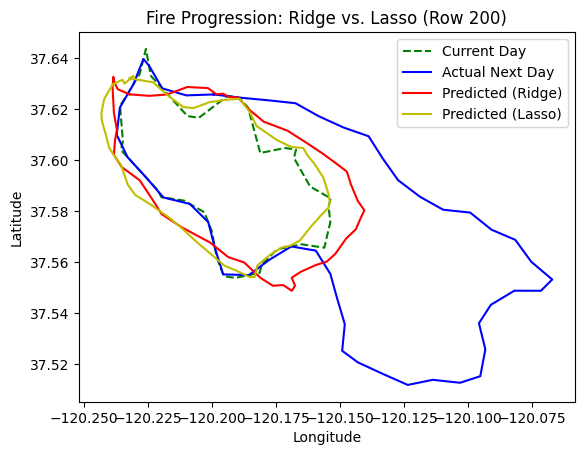

Row 200
Current Polygon (WKT): POLYGON ((-120.2238 37.63312, -120.21667 37.62521, -120.20946 37.61729, -120.20505 37.61663, -120.1938 37.62523, -120.18945 37.62458, -120.18581 37.62061, -120.18106 37.6028, -120.1714 37.60479, -120.1671 37.60414, -120.16788 37.60084, -120.16155 37.58963, -120.15356 37.58503, -120.15435 37.58172, -120.15369 37.57555, -120.15449 37.57224, -120.15527 37.56894, -120.15603 37.56564, -120.16048 37.56631, -120.16489 37.56698, -120.17446 37.56499, -120.18046 37.55906, -120.1813 37.55576, -120.19088 37.55378, -120.19527 37.55444, -120.19802 37.56169, -120.20002 37.57225, -120.20289 37.57953, -120.21086 37.58415, -120.21523 37.58481, -120.21964 37.58547, -120.22111 37.58821, -120.2247 37.59217, -120.22829 37.59612, -120.23189 37.60008, -120.23551 37.60404, -120.2347 37.60735, -120.23584 37.62122, -120.22819 37.63377, -120.22734 37.63707, -120.22573 37.64367, -120.2238 37.63312))
Actual Next-Day Polygon (WKT): POLYGON ((-120.19926 37.6258, -120.1938 37.62523, -120

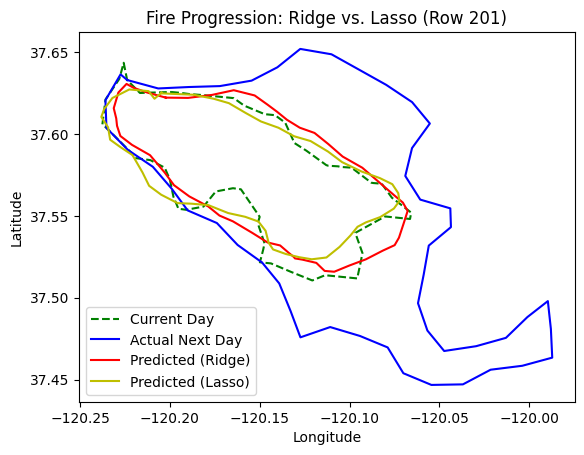

Row 201
Current Polygon (WKT): POLYGON ((-120.19926 37.6258, -120.1938 37.62523, -120.18945 37.62458, -120.18124 37.62386, -120.17567 37.62326, -120.16444 37.62205, -120.15864 37.61745, -120.14726 37.61225, -120.14149 37.61163, -120.13583 37.60705, -120.13069 37.5946, -120.12405 37.58993, -120.11295 37.58109, -120.11184 37.58071, -120.10634 37.58035, -120.10523 37.58001, -120.09978 37.57961, -120.09863 37.57932, -120.08791 37.57036, -120.08685 37.57015, -120.08208 37.56971, -120.07643 37.56116, -120.07098 37.5566, -120.06571 37.55206, -120.06635 37.54818, -120.07281 37.54889, -120.08023 37.54972, -120.09682 37.53968, -120.09284 37.52736, -120.09352 37.52348, -120.09423 37.51959, -120.095 37.51572, -120.09575 37.51184, -120.10183 37.5125, -120.10773 37.51315, -120.11365 37.51379, -120.12074 37.51059, -120.13261 37.51584, -120.14375 37.52102, -120.14994 37.52169, -120.14897 37.52555, -120.14808 37.52943, -120.14732 37.53331, -120.15112 37.54564, -120.15003 37.5495, -120.16048 37.56631, -

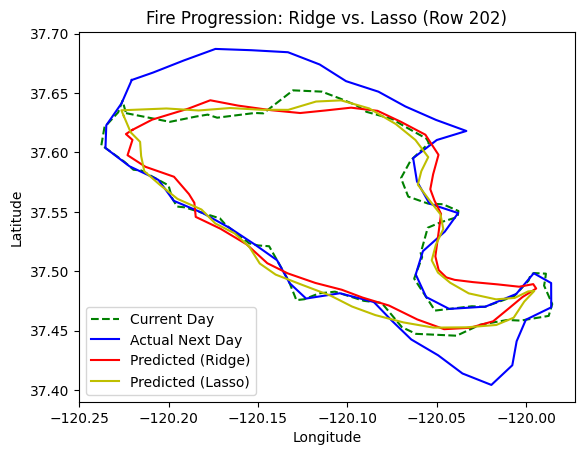

Row 202
Current Polygon (WKT): POLYGON ((-120.2238 37.63312, -120.19926 37.6258, -120.18452 37.63029, -120.17812 37.63189, -120.17281 37.6293, -120.15174 37.63327, -120.14699 37.63296, -120.13039 37.65233, -120.12623 37.65205, -120.12186 37.65176, -120.11799 37.6515, -120.11427 37.65125, -120.10415 37.64546, -120.09502 37.63974, -120.08932 37.63425, -120.07493 37.62819, -120.06884 37.62269, -120.05576 37.61163, -120.05436 37.60784, -120.05533 37.60651, -120.06459 37.59328, -120.07001 37.57838, -120.06596 37.56282, -120.05489 37.55696, -120.04655 37.55639, -120.03791 37.55071, -120.03836 37.54566, -120.04778 37.54122, -120.05504 37.53662, -120.05899 37.51519, -120.05817 37.51186, -120.06264 37.49372, -120.05099 37.46682, -120.03036 37.47046, -120.02316 37.46994, -120.00672 37.47892, -119.99858 37.49219, -119.99752 37.4972, -119.99557 37.49841, -119.98897 37.49792, -119.98939 37.49289, -119.98999 37.48786, -119.98543 37.47233, -119.98643 37.46734, -119.98741 37.46234, -120.00309 37.45838

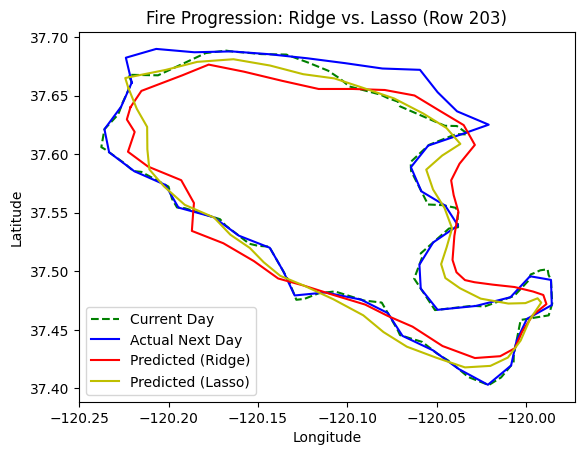

Row 203
Current Polygon (WKT): POLYGON ((-120.22057 37.66105, -120.22233 37.66768, -120.21471 37.66747, -120.20588 37.66723, -120.17923 37.68621, -120.1679 37.68832, -120.16371 37.68742, -120.1564 37.68655, -120.14822 37.68535, -120.14075 37.68513, -120.13413 37.68495, -120.12181 37.67805, -120.11078 37.67119, -120.10416 37.66446, -120.09896 37.65778, -120.08151 37.65076, -120.07739 37.64779, -120.07171 37.64476, -120.0706 37.64077, -120.04549 37.62416, -120.03879 37.62395, -120.03267 37.61724, -120.03294 37.61683, -120.03928 37.61699, -120.05436 37.60784, -120.05533 37.60651, -120.06459 37.59328, -120.06437 37.58561, -120.05489 37.55696, -120.04655 37.55639, -120.03948 37.55416, -120.03791 37.55071, -120.03794 37.55026, -120.03836 37.54566, -120.03809 37.53754, -120.04316 37.53646, -120.05899 37.51519, -120.05817 37.51186, -120.06264 37.49372, -120.05099 37.46682, -120.03036 37.47046, -120.02316 37.46994, -120.00672 37.47892, -119.99858 37.49219, -119.99752 37.4972, -119.99557 37.4984

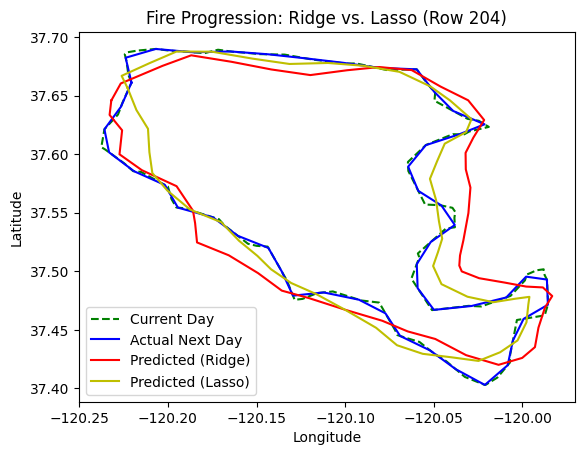

Row 204
Current Polygon (WKT): POLYGON ((-120.22057 37.66105, -120.22233 37.66768, -120.22335 37.67908, -120.22436 37.68525, -120.22292 37.68691, -120.21715 37.68841, -120.20662 37.6898, -120.20061 37.68858, -120.17923 37.68621, -120.17175 37.68911, -120.1679 37.68832, -120.16371 37.68742, -120.1564 37.68655, -120.14822 37.68535, -120.14075 37.68513, -120.13413 37.68495, -120.1187 37.68078, -120.09927 37.67725, -120.09383 37.67744, -120.07662 37.67179, -120.07152 37.67197, -120.06606 37.67215, -120.0596 37.67237, -120.05365 37.66008, -120.04922 37.65226, -120.04962 37.64559, -120.03094 37.6301, -120.02914 37.62963, -120.02459 37.62844, -120.01895 37.62323, -120.02991 37.61936, -120.03294 37.61683, -120.03928 37.61699, -120.05436 37.60784, -120.05533 37.60651, -120.06459 37.59328, -120.06437 37.58561, -120.05489 37.55696, -120.04655 37.55639, -120.03948 37.55416, -120.03791 37.55071, -120.03794 37.55026, -120.03836 37.54566, -120.03809 37.53754, -120.04316 37.53646, -120.05899 37.51519,

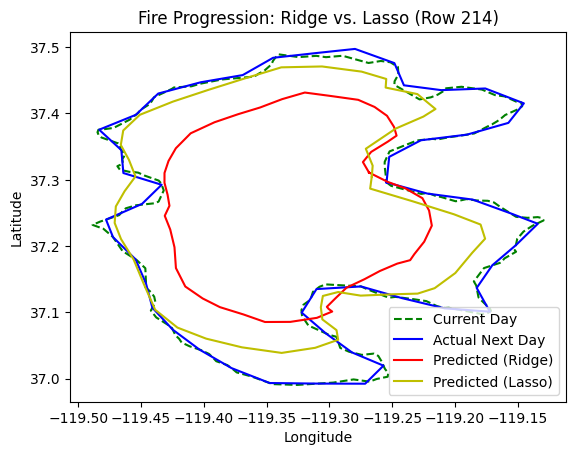

Row 214
Current Polygon (WKT): POLYGON ((-119.25446 37.29611, -119.25084 37.29092, -119.2268 37.27871, -119.22357 37.27972, -119.22147 37.27906, -119.21928 37.27861, -119.21551 37.2758, -119.21109 37.27408, -119.19952 37.26768, -119.19711 37.2682, -119.19089 37.27087, -119.18306 37.26892, -119.18068 37.26867, -119.17381 37.26834, -119.1688 37.26572, -119.16451 37.25988, -119.15147 37.24436, -119.15068 37.24403, -119.14214 37.24266, -119.13407 37.24374, -119.13127 37.24258, -119.12949 37.23944, -119.12948 37.23866, -119.13841 37.2305, -119.14262 37.22524, -119.14539 37.2219, -119.15038 37.21096, -119.15235 37.19368, -119.15128 37.19157, -119.16045 37.1816, -119.1629 37.1763, -119.16415 37.17475, -119.17682 37.16693, -119.18491 37.14671, -119.18303 37.14061, -119.1813 37.12349, -119.18098 37.1219, -119.1721 37.10562, -119.1713 37.10233, -119.17288 37.10022, -119.17477 37.09836, -119.17904 37.09767, -119.20496 37.10706, -119.20591 37.10692, -119.20818 37.10667, -119.2142 37.10947, -119.22

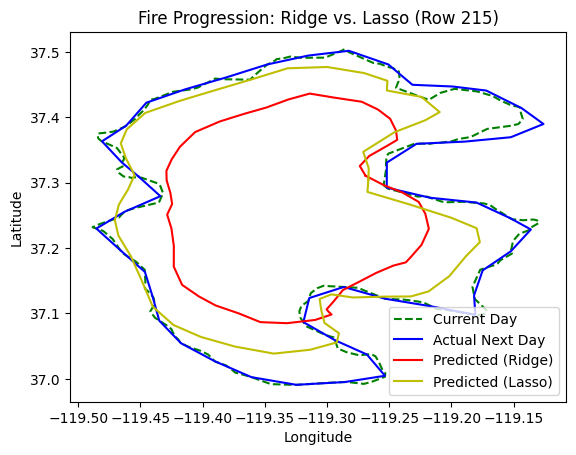

Row 215
Current Polygon (WKT): POLYGON ((-119.25446 37.29611, -119.25084 37.29092, -119.2268 37.27871, -119.225 37.27927, -119.22457 37.27907, -119.22357 37.27972, -119.22147 37.27906, -119.21928 37.27861, -119.21551 37.2758, -119.21401 37.27522, -119.2076 37.27108, -119.20335 37.27016, -119.19089 37.27087, -119.18031 37.2694, -119.17381 37.26834, -119.1688 37.26572, -119.16451 37.25988, -119.15147 37.24436, -119.15068 37.24403, -119.14214 37.24266, -119.13407 37.24374, -119.13127 37.24258, -119.12949 37.23944, -119.12948 37.23866, -119.13613 37.23132, -119.13765 37.22735, -119.14539 37.2219, -119.15038 37.21096, -119.15235 37.19368, -119.15128 37.19157, -119.16045 37.1816, -119.1629 37.1763, -119.16415 37.17475, -119.17169 37.17029, -119.17682 37.16693, -119.18232 37.14352, -119.18303 37.14061, -119.1813 37.12349, -119.18098 37.1219, -119.1721 37.10562, -119.1713 37.10233, -119.17288 37.10022, -119.17477 37.09836, -119.17904 37.09767, -119.20476 37.10543, -119.20857 37.10625, -119.212

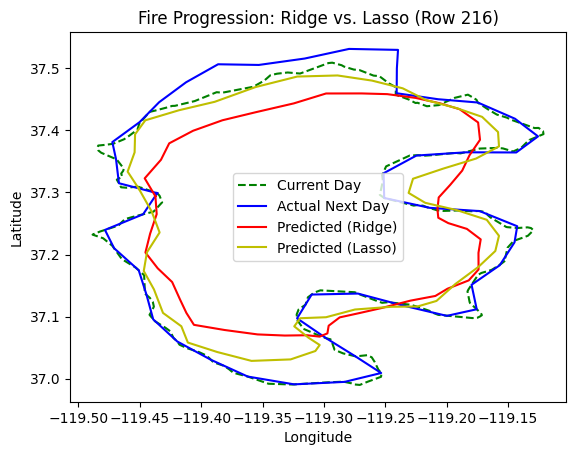

Row 216
Current Polygon (WKT): POLYGON ((-119.45143 37.30934, -119.46091 37.3075, -119.46529 37.30824, -119.46696 37.31445, -119.4688 37.32054, -119.46631 37.3231, -119.46431 37.32487, -119.4652 37.33032, -119.4636 37.33468, -119.46303 37.33819, -119.46894 37.35317, -119.48147 37.3638, -119.48382 37.36753, -119.4842 37.37, -119.48463 37.37146, -119.4839 37.37541, -119.47793 37.37662, -119.47179 37.37821, -119.46285 37.38555, -119.45878 37.39087, -119.45861 37.39127, -119.45856 37.39132, -119.4519 37.40121, -119.45135 37.40472, -119.45088 37.40824, -119.45067 37.4099, -119.45013 37.41116, -119.44379 37.42585, -119.44295 37.42918, -119.43752 37.43171, -119.42599 37.43769, -119.42381 37.43918, -119.42142 37.43935, -119.41074 37.44446, -119.40531 37.447, -119.38974 37.45942, -119.38742 37.46128, -119.3828 37.4605, -119.35753 37.47005, -119.3485 37.48016, -119.34369 37.48852, -119.33826 37.49107, -119.32957 37.49303, -119.32839 37.49285, -119.32392 37.49209, -119.31946 37.49133, -119.29627 

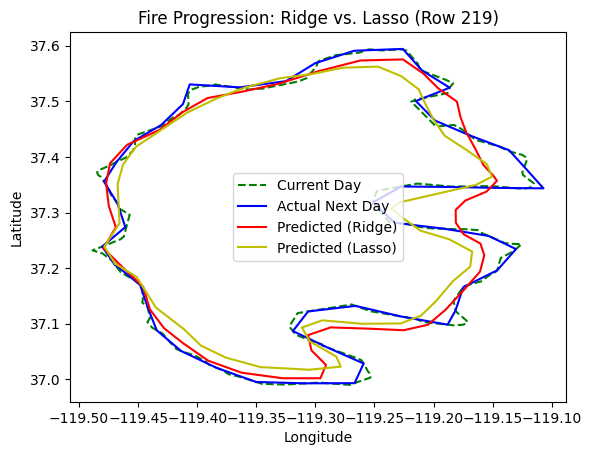

Row 219
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45711 37.29616, -119.46532 37.30622, -119.46696 37.31445, -119.4688 37.32054, -119.47271 37.33104, -119.47692 37.34998, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47252 37.38584, -119.47101 37.38795, -119.46013 37.39898, -119.45418 37.41148, -119.45248 37.42378, -119.45269 37.42537, -119.4524 37.42803, -119.45244 37.43292, -119.45176 37.43645, -119.45064 37.43988, -119.43101 37.45443, -119.4209 37.47024, -119.41528 37.47572, -119.40934 37.48746, -119.40832 37.49091, -119.40732 37.49436, -119.40776 37.51261, -119.40705 37.51612, -119.40633 37.51962, -119.39819 37.52608, -119.3881 37.52835, -119.38454 37.53011, -119.35674 37.52112, -119.35596 37.5212, -119.34484 37.52277, -119.31464 37.53541, -119.30755 37.54139, -119.29946 37.56165, -11

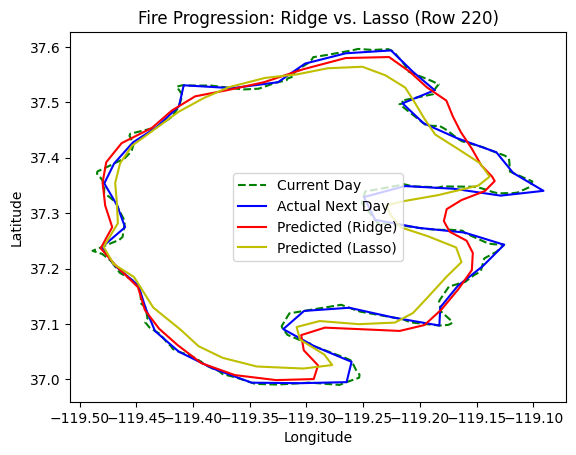

Row 220
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45999 37.28482, -119.46532 37.30622, -119.46696 37.31445, -119.4688 37.32054, -119.47457 37.33058, -119.47842 37.33459, -119.47808 37.34638, -119.47799 37.35285, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47203 37.38691, -119.46013 37.39898, -119.45418 37.41148, -119.45248 37.42378, -119.45598 37.43974, -119.45531 37.44309, -119.45024 37.44566, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41451 37.52801, -119.40918 37.53069, -119.40479 37.53006, -119.38454 37.53011, -119.35577 37.52298, -119.34196 37.52443, -119.32726 37.53505, -119.31753 37.53955, -119.31653 37.54281, -119.31208 37.54602, -119.31134 37.54936, -119.31059 37.55268, 

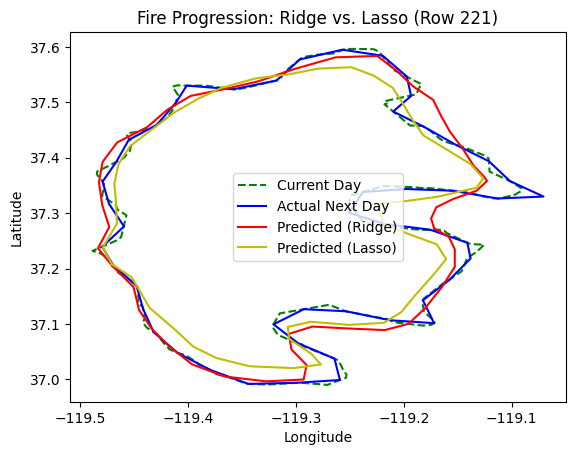

Row 221
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45711 37.29616, -119.46532 37.30622, -119.46696 37.31445, -119.47983 37.33145, -119.47922 37.33551, -119.47808 37.34638, -119.47799 37.35285, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47203 37.38691, -119.46013 37.39898, -119.45418 37.41148, -119.45248 37.42378, -119.45341 37.43105, -119.45653 37.43961, -119.45625 37.44371, -119.45313 37.44515, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40479 37.53006, -119.38454 37.53011, -119.35577 37.52298, -119.34536 37.52668, -119.31753 37.53955, -119.31716 37.54075, -119.31445 37.5421, -119.31179 37.55183, -

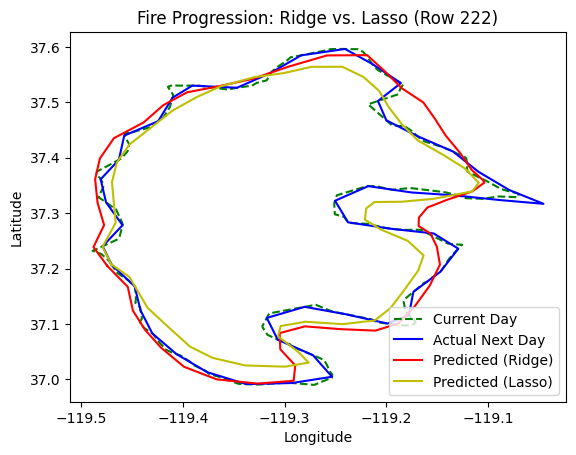

Row 222
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.47799 37.35285, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47203 37.38691, -119.46013 37.39898, -119.45418 37.41148, -119.45248 37.42378, -119.4567 37.43806, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40479 37.53006, -119.38454 37.53011, -119.35577 37.52298, -119.34536 37.52668, -119.33202 37.52993, -119.32737 37.535, -119.31753 37.53955, -119.31274 37.55513, -119.30579 37.56527, -119.

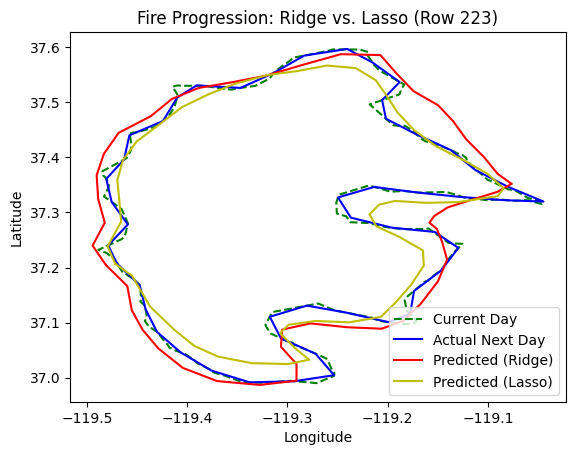

Row 223
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.47799 37.35285, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47203 37.38691, -119.46013 37.39898, -119.45615 37.41221, -119.45544 37.42033, -119.4567 37.43806, -119.45818 37.44163, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40479 37.53006, -119.38454 37.53011, -119.35577 37.52298, -119.34536 37.52668, -119.33202 37.52993, -119.3179 37.54312, -119.31274 37.55513, -119.30579 37.56527, -119

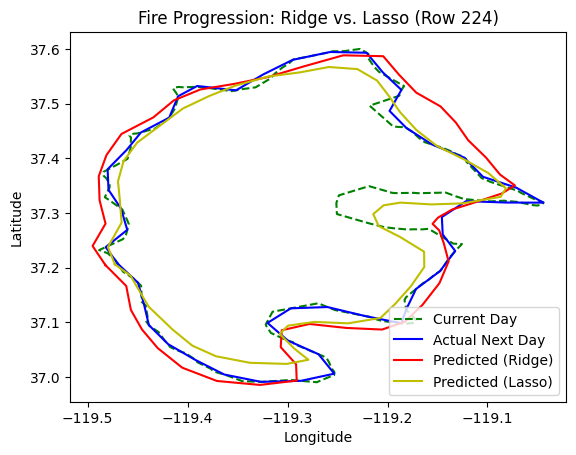

Row 224
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.47991 37.22615, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.47799 37.35285, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47203 37.38691, -119.46013 37.39898, -119.45696 37.41909, -119.4567 37.43806, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40479 37.53006, -119.39128 37.53081, -119.38454 37.53011, -119.35577 37.52298, -119.34536 37.52668, -119.33202 37.52993, -119.31697 37.54633, -119.31274 37.55513, -11

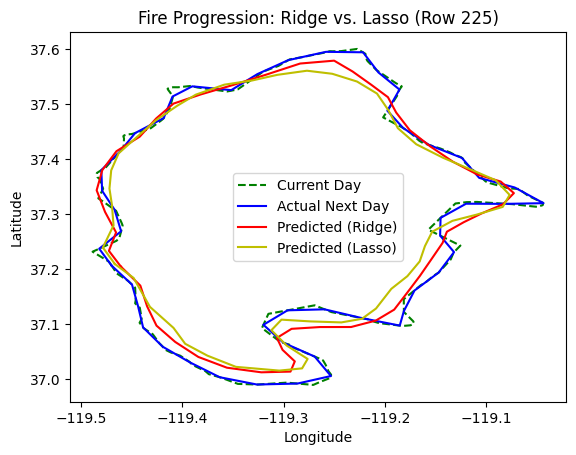

Row 225
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47518 37.3857, -119.45791 37.42181, -119.4575 37.43777, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40419 37.53064, -119.39187 37.533, -119.38454 37.53011, -119.35577 37.52298, -119.34536 37.52668, -119.3204 37.55876, -119.31948 37.55959, -119.3052 37.56934, -119.29402 37.58126, -119.27959 37.58605, -119.27137 37.58923, -119.259

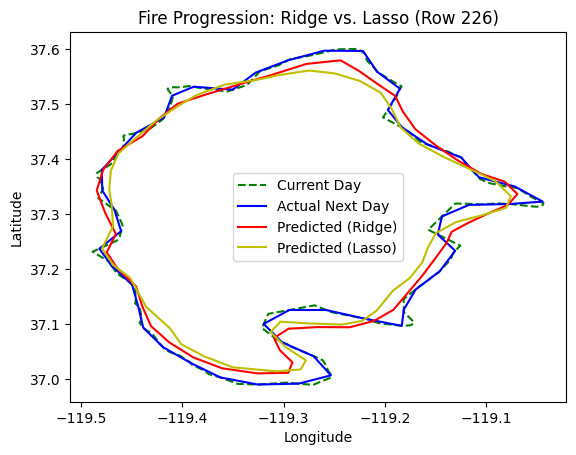

Row 226
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47518 37.3857, -119.47076 37.39055, -119.45837 37.42131, -119.4575 37.43777, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40419 37.53064, -119.39187 37.533, -119.38454 37.53011, -119.35577 37.52298, -119.33622 37.53469, -119.32606 37.55413, -119.32385 37.55908, -119.32059 37.56144, -119.30465 37.57084, -119.29402 37.58126, -119.2

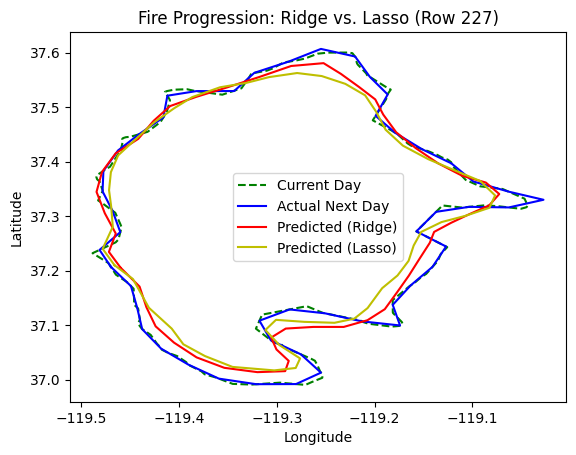

Row 227
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47518 37.3857, -119.47191 37.3894, -119.47076 37.39055, -119.45979 37.42052, -119.4575 37.43777, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40524 37.53217, -119.39187 37.533, -119.38454 37.53011, -119.35577 37.52298, -119.33622 37.53469, -119.32858 37.5541, -119.32723 37.55804, -119.32591 37.56198, -119.31023 37.56707, -119.305

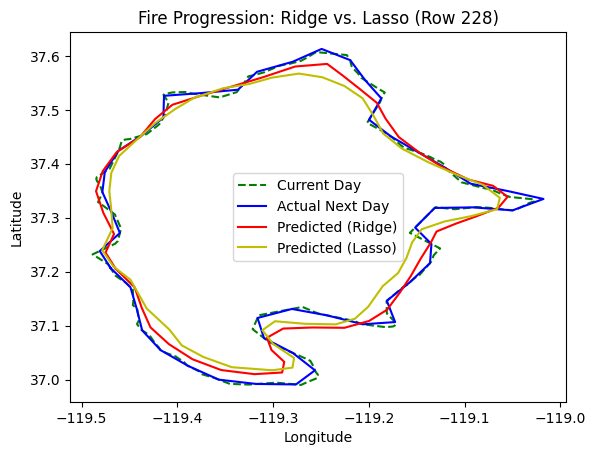

Row 228
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47518 37.3857, -119.47191 37.3894, -119.47076 37.39055, -119.46149 37.42421, -119.46056 37.42752, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40524 37.53217, -119.39187 37.533, -119.38454 37.53011, -119.35577 37.52298, -119.33798 37.53281, -119.32858 37.5541, -119.32723 37.55804, -119.32591 37.56198, -119.31969 37.56443, -119.31

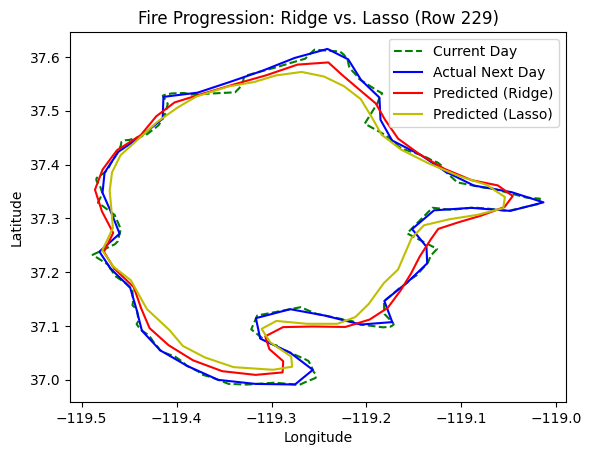

Row 229
Current Polygon (WKT): POLYGON ((-119.46972 37.20671, -119.4724 37.21395, -119.48853 37.232, -119.48251 37.23696, -119.46488 37.25187, -119.46206 37.25702, -119.45888 37.2796, -119.45999 37.28482, -119.46532 37.30622, -119.47818 37.32321, -119.48285 37.32883, -119.47808 37.34638, -119.48147 37.3638, -119.48382 37.36753, -119.48463 37.37146, -119.48425 37.37507, -119.4839 37.37541, -119.47518 37.3857, -119.47231 37.39348, -119.47113 37.39502, -119.47008 37.39979, -119.46149 37.42421, -119.46056 37.42752, -119.45871 37.43588, -119.45818 37.44163, -119.45785 37.44254, -119.4571 37.44341, -119.45439 37.44493, -119.44981 37.44574, -119.43227 37.45477, -119.4209 37.47024, -119.41876 37.47352, -119.41257 37.49144, -119.40929 37.51278, -119.41181 37.52074, -119.41381 37.52559, -119.41451 37.52801, -119.4125 37.52956, -119.40918 37.53069, -119.40524 37.53217, -119.39187 37.533, -119.38454 37.53011, -119.33836 37.53425, -119.33095 37.54756, -119.32932 37.5607, -119.3275 37.56497, -119.32

In [260]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Polygon
from joblib import load

# Define the `resample_polygon` function
def resample_polygon(poly, n_points=50):
    coords = np.array(poly.exterior.coords)
    perimeter = sum(
        np.hypot(coords[i + 1, 0] - coords[i, 0], coords[i + 1, 1] - coords[i, 1])
        for i in range(len(coords) - 1)
    )
    spacing = perimeter / (n_points - 1)

    resampled = []
    segment_start = 0.0
    current_segment = 0

    for i in range(n_points):
        target_dist = i * spacing
        while True:
            p1 = coords[current_segment]
            p2 = coords[current_segment + 1]
            seg_len = np.hypot(p2[0] - p1[0], p2[1] - p1[1])

            if segment_start + seg_len >= target_dist or current_segment == len(coords) - 2:
                ratio = (target_dist - segment_start) / seg_len if seg_len else 0
                lon = p1[0] + ratio * (p2[0] - p1[0])
                lat = p1[1] + ratio * (p2[1] - p1[1])
                resampled.append([lon, lat])
                break
            else:
                segment_start += seg_len
                current_segment += 1

    return np.array(resampled).flatten()

# Load the Ridge and Lasso models
ridge_model = load("ridge_model.joblib")
lasso_model = load("lasso_model.joblib")

# Process rows dynamically
for idx, row in df.iloc[190:230].iterrows():
    current_poly = loads(row["geometry"])  # Current polygon
    actual_next_poly = loads(row["geometry_next"])  # Next day actual polygon

    try:
        # Resample polygons
        resampled_current = resample_polygon(current_poly, n_points=50)
        resampled_actual = resample_polygon(actual_next_poly, n_points=50)
    except:
        continue

    # Prepare features
    direction = row["direction"]
    temperature = row["temperature"]
    windspeed = row["windspeed"]
    X_new = np.concatenate(([direction, temperature, windspeed], resampled_current)).reshape(1, -1)

    # Predict next-day polygon using Ridge and Lasso
    y_pred_ridge = ridge_model.predict(X_new)
    y_pred_lasso = lasso_model.predict(X_new)

    # Reshape predictions
    ridge_coords = y_pred_ridge[0].reshape(-1, 2)
    lasso_coords = y_pred_lasso[0].reshape(-1, 2)

    # Create polygons
    ridge_poly = Polygon(ridge_coords)
    lasso_poly = Polygon(lasso_coords)

    # Plot current, actual, and predicted polygons
    fig, ax = plt.subplots()

    # Current polygon
    current_coords = np.array(current_poly.exterior.coords)
    ax.plot(current_coords[:, 0], current_coords[:, 1], 'g--', label='Current Day')

    # Actual next-day polygon (resampled)
    actual_coords = resampled_actual.reshape(-1, 2)
    ax.plot(actual_coords[:, 0], actual_coords[:, 1], 'b-', label='Actual Next Day')

    # Ridge predicted polygon
    ridge_coords[:, 1] += 0.0005  # Offset for clarity
    ax.plot(ridge_coords[:, 0], ridge_coords[:, 1], 'r-', label='Predicted (Ridge)')

    # Lasso predicted polygon
    lasso_coords[:, 1] -= 0.0005  # Offset for clarity
    ax.plot(lasso_coords[:, 0], lasso_coords[:, 1], 'y-', label='Predicted (Lasso)')

    # Finalize plot
    ax.legend()
    ax.set_title(f'Fire Progression: Ridge vs. Lasso (Row {idx})')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    plt.close()

    # Print polygon WKT data
    print(f"Row {idx}")
    print("Current Polygon (WKT):", current_poly.wkt)
    print("Actual Next-Day Polygon (WKT):", actual_next_poly.wkt)
    print("Ridge Predicted Polygon (WKT):", ridge_poly.wkt)
    print("Lasso Predicted Polygon (WKT):", lasso_poly.wkt)





In [268]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from joblib import load
from shapely.geometry import mapping
from shapely.wkt import loads
from shapely.geometry import shape

# Load Lasso model
lasso_model = load("lasso_model.joblib")


def get_largest_polygon(poly):
    """
    If 'poly' is a MultiPolygon, return the sub-polygon with the largest area.
    If it's already a Polygon, return it as is.
    """
    if isinstance(poly, MultiPolygon):
        return max(poly.geoms, key=lambda g: g.area)
    elif isinstance(poly, Polygon):
        return poly
    else:
        raise ValueError(f"Geometry is neither Polygon nor MultiPolygon: {type(poly)}")


def resample_polygon(poly, n_points=50):
    coords = np.array(poly.exterior.coords)
    perimeter = sum(
        np.hypot(coords[i + 1, 0] - coords[i, 0], coords[i + 1, 1] - coords[i, 1])
        for i in range(len(coords) - 1)
    )
    spacing = perimeter / (n_points - 1)

    resampled = []
    segment_start = 0.0
    current_segment = 0

    for i in range(n_points):
        target_dist = i * spacing
        while True:
            p1 = coords[current_segment]
            p2 = coords[current_segment + 1]
            seg_len = np.hypot(p2[0] - p1[0], p2[1] - p1[1])

            if segment_start + seg_len >= target_dist or current_segment == len(coords) - 2:
                ratio = (target_dist - segment_start) / seg_len if seg_len else 0
                lon = p1[0] + ratio * (p2[0] - p1[0])
                lat = p1[1] + ratio * (p2[1] - p1[1])
                resampled.append([lon, lat])
                break
            else:
                segment_start += seg_len
                current_segment += 1

    return np.array(resampled).flatten()


def predict_and_plot(temp, wind_speed, wind_direction, geojson_poly, n_points=50, is_geojson=True):
    """
    Predicts next-day polygon based on weather and geometry data, plots it,
    and returns GeoJSON-formatted polygon.

    If the geometry is a MultiPolygon, the largest sub-polygon (by area)
    is used for processing.
    """

    try:
        if geojson_poly is None:
            raise ValueError("Input polygon (geojson_poly) is None. Please provide a valid polygon.")

        # 1) Convert the input geometry (GeoJSON or WKT) to a Shapely polygon
        if is_geojson:
            if isinstance(geojson_poly, dict):
                # If the top-level key is "lasso_polygon", use that for shape()
                if "lasso_polygon" in geojson_poly:
                    current_poly = shape(geojson_poly["lasso_polygon"])
                else:
                    current_poly = shape(geojson_poly)
            else:
                raise TypeError("Expected a GeoJSON dictionary when is_geojson is True.")
        else:
            if not isinstance(geojson_poly, str):
                raise TypeError("Expected a WKT string when is_geojson is False.")
            current_poly = loads(geojson_poly)

        # 2) If it's MultiPolygon, pick the largest one
        current_poly = get_largest_polygon(current_poly)

        # 3) Resample polygon
        resampled_current = resample_polygon(current_poly, n_points=n_points)

        # 4) Prepare features for Lasso
        X_new = np.concatenate(([wind_direction, temp, wind_speed], resampled_current)).reshape(1, -1)

        # 5) Predict next-day polygon
        y_pred_lasso = lasso_model.predict(X_new)
        lasso_coords = y_pred_lasso[0].reshape(-1, 2)
        lasso_poly = Polygon(lasso_coords)

        # 6) Plot only the predicted polygon
        fig, ax = plt.subplots()
        ax.plot(lasso_coords[:, 0], lasso_coords[:, 1], 'y-', label='Predicted (Lasso)')

        ax.legend()
        ax.set_title('Polygon Prediction: Lasso')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
        plt.close()

        return {"lasso_polygon": mapping(lasso_poly)}

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


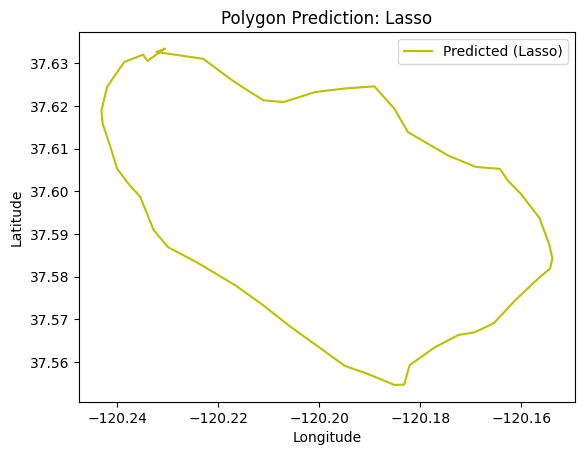

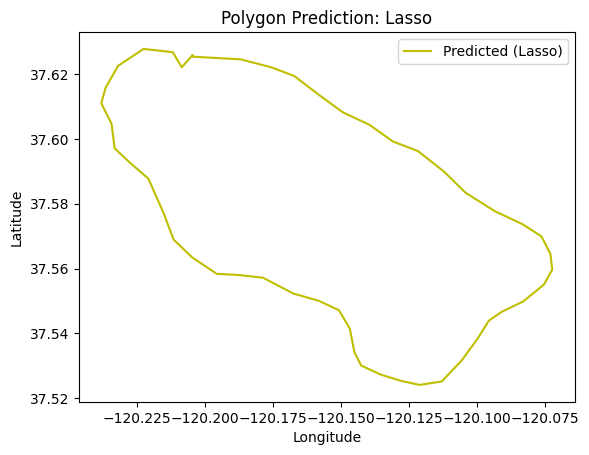

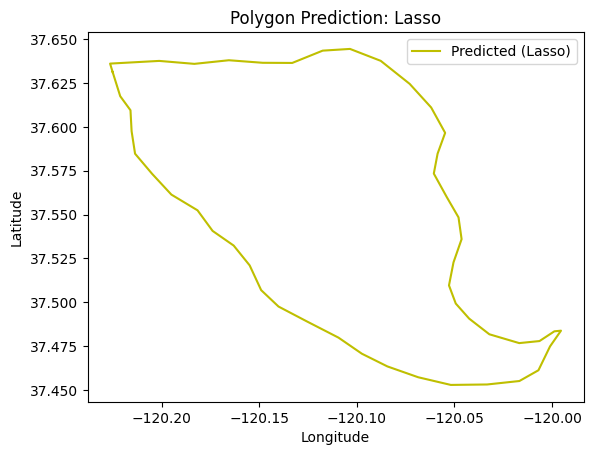

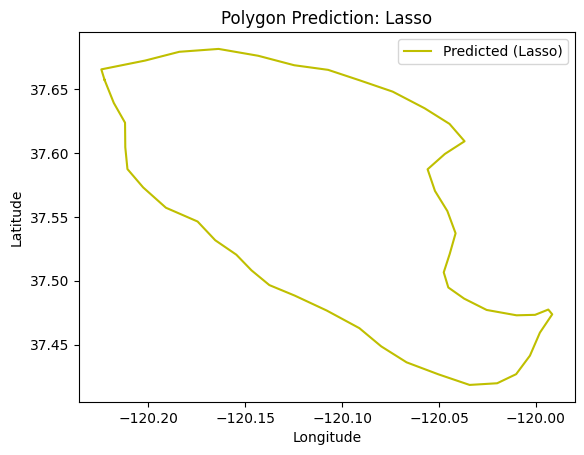

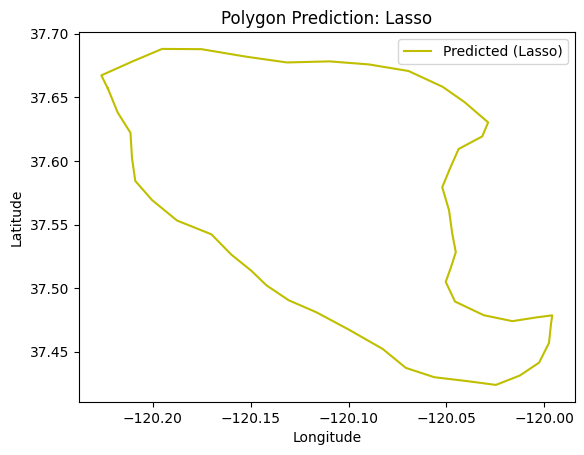

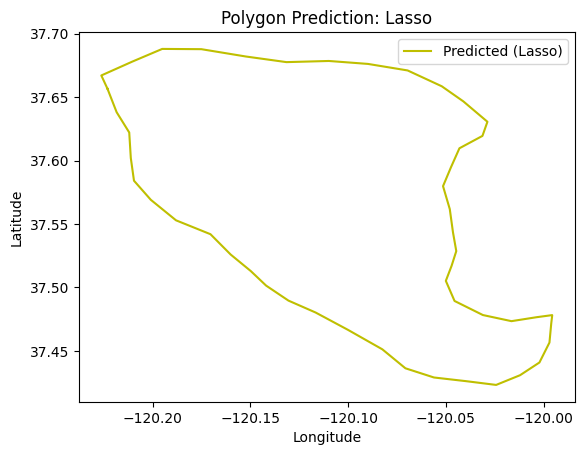

An error occurred: 'MultiPolygon' object has no attribute 'exterior'


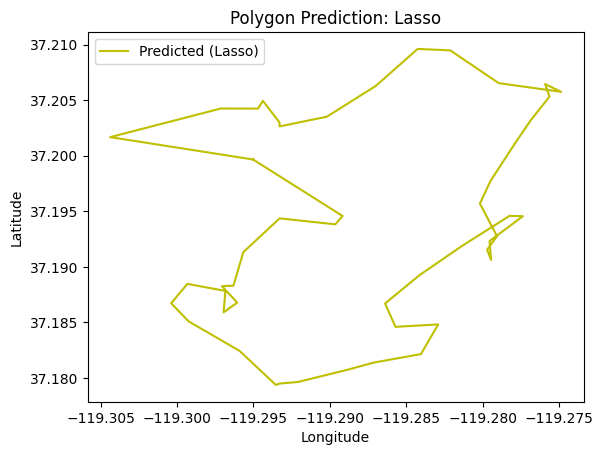

An error occurred: 'MultiPolygon' object has no attribute 'exterior'


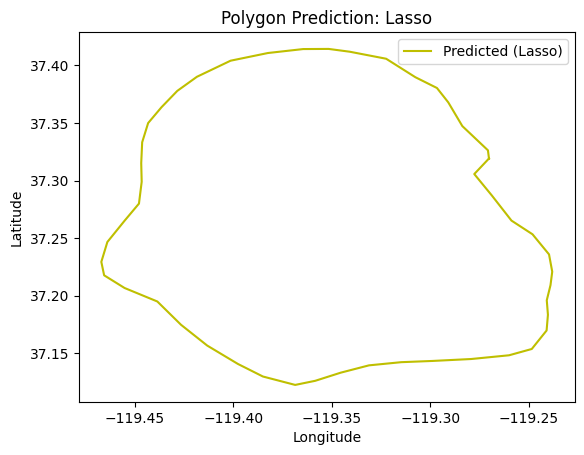

An error occurred: 'MultiPolygon' object has no attribute 'exterior'
An error occurred: 'MultiPolygon' object has no attribute 'exterior'
An error occurred: 'MultiPolygon' object has no attribute 'exterior'
An error occurred: 'MultiPolygon' object has no attribute 'exterior'


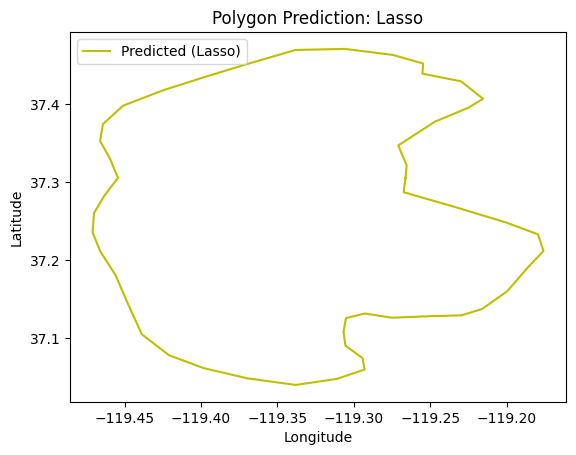

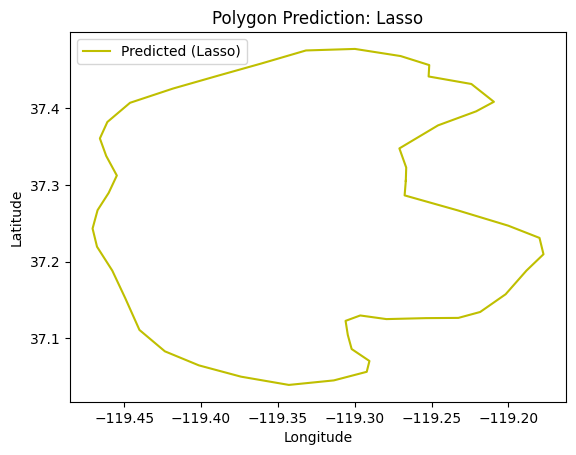

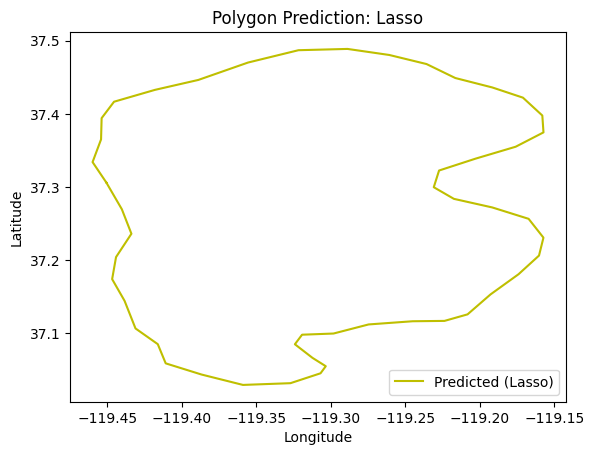

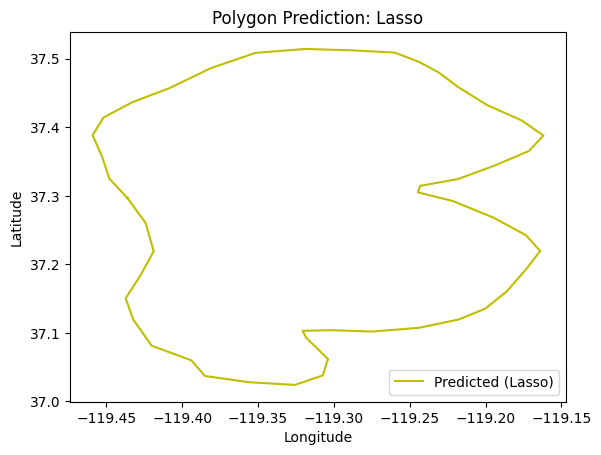

An error occurred: 'MultiPolygon' object has no attribute 'exterior'


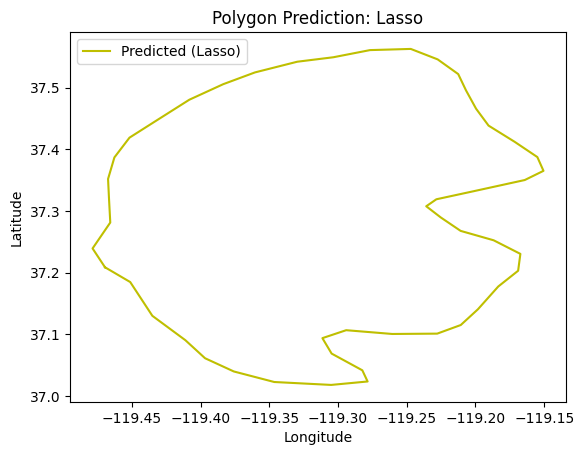

In [259]:
for i in range(200,220):
  predict_and_plot(df.loc[i, "temperature"], df.loc[i, "windspeed"], df.loc[i, "direction"], df.loc[i, "geometry"], n_points=50, is_geojson = False)

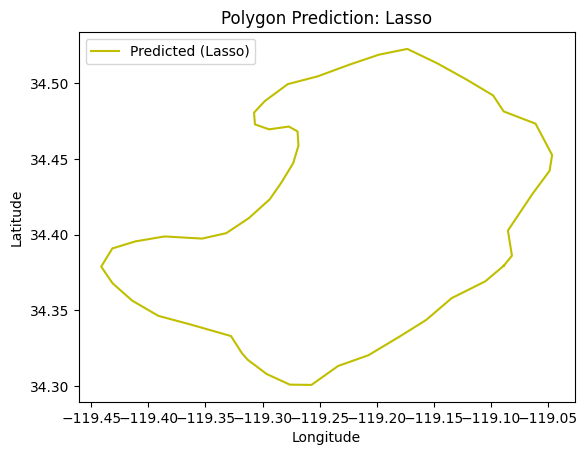

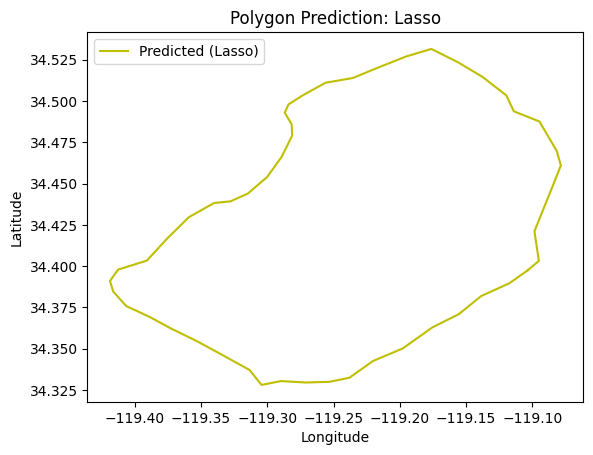

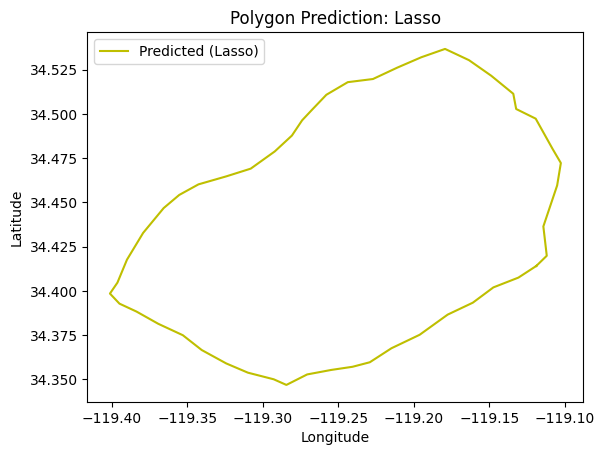

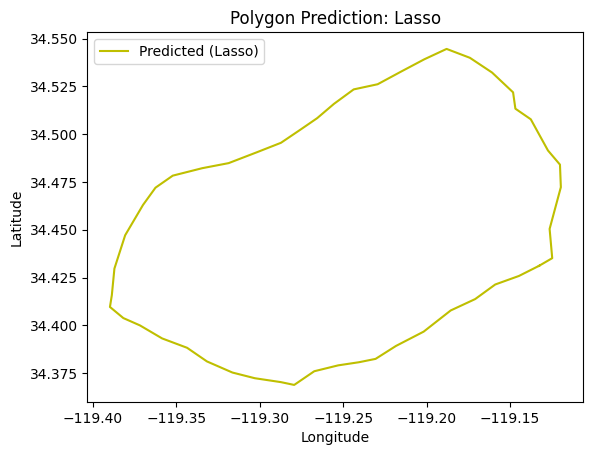

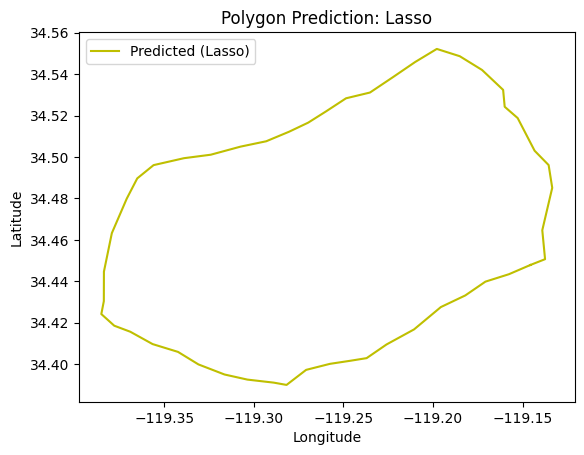

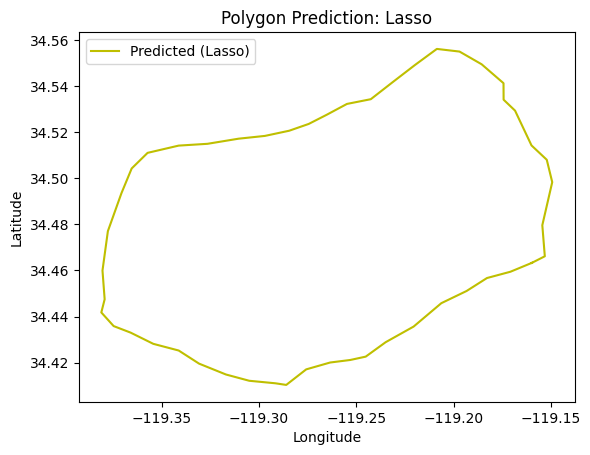

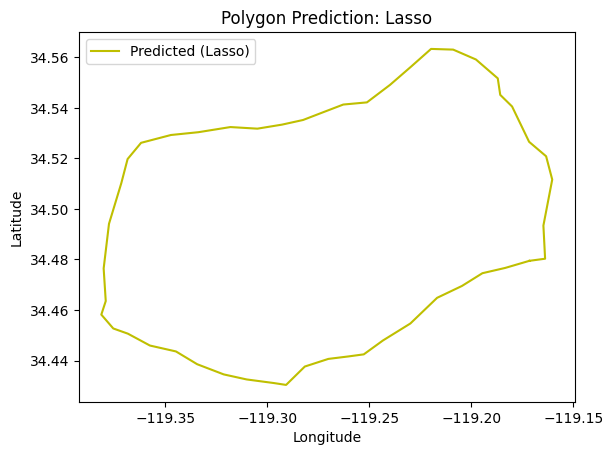

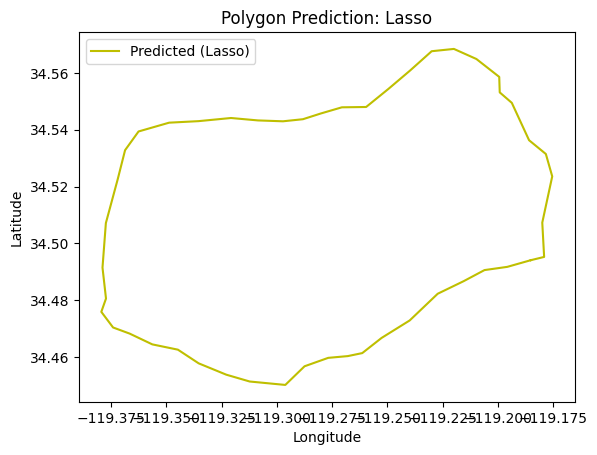

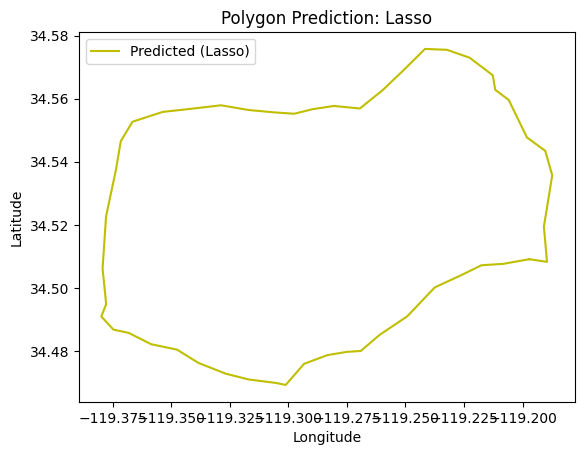

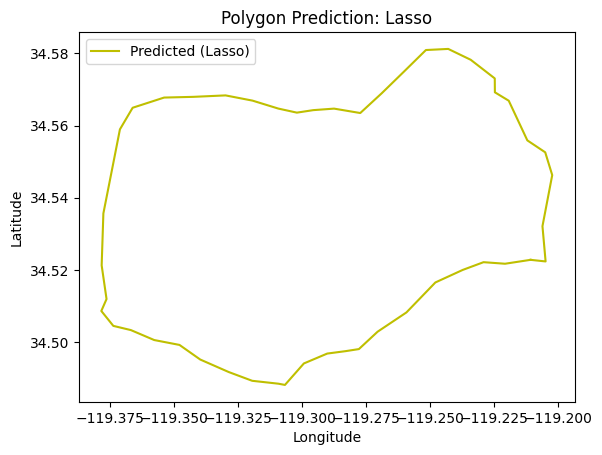

In [270]:
start = 182
geo_info = predict_and_plot(df.loc[start, "temperature"], df.loc[start, "windspeed"], df.loc[start, "direction"], df.loc[start, "geometry"], n_points=50, is_geojson = False)

for i in range(1, 10):
  geo_info = predict_and_plot(df.loc[start+i, "temperature"], df.loc[start+i, "windspeed"], df.loc[start+i, "direction"], geo_info, n_points=50, is_geojson = True)
